
# Clustering hérarchique sur les caractéristiques des joueurs de football



Import des fonctions et des librairies utiles


In [118]:
import numpy as np
import pandas as pd
import math
import random
import time

import functions
import functions.kmoyenne as km
import functions.clustering as cl #fonctions du TME
import functions.clustering2 as cl2
#fonctions du TME avec amélioration de clustering hierarchique avec une heapq pour le calcul des distance qui 
# est gardé d'une itération à l'autre

import scipy.cluster.hierarchy
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline


Chargement de la base de données des caractéristiques des joueurs

In [119]:
player_attribute = pd.read_csv("soccer/playerattributes.csv")
player_attribute[0:4]

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67,71,right,medium,medium,49,...,54,48,65,69,69,6,11,10,8,8
1,2,218353,505942,2015-11-19 00:00:00,67,71,right,medium,medium,49,...,54,48,65,69,69,6,11,10,8,8
2,3,218353,505942,2015-09-21 00:00:00,62,66,right,medium,medium,49,...,54,48,65,66,69,6,11,10,8,8
3,4,218353,505942,2015-03-20 00:00:00,61,65,right,medium,medium,48,...,53,47,62,63,66,5,10,9,7,7


Chargement de la base de données des joueurs

In [120]:
df_player_name = pd.read_csv("soccer/player.csv")
df_player_name[0:4]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198


## Fonctions utiles

Création d'un fonction permettant de creer un dataframe des caractéristiques des joueurs, en ne gardant que ma ligne la plus récente pour chaque joueur. Cette fonction transforme les valeurs litterales en valeurs numeriques, mais aussi renvoie la liste des palyer_api_id des joueurs dans l'ordre du dataframe

In [121]:
def create_df_player_attributes(dataframe):
    """permet de creer un nouveau dataframe, en ne 
    gardant que ma ligne la plus récente pour chaque joueur
    transforme aussi les valeurs litterales en valeurs numeriques
    """
    new_df = dict()
    for column in dataframe.columns:
        new_df[column] = []
    
    players_id = set()
    players_id_list = []
    for i in range(len(dataframe)):
        player = dataframe.iloc[i]
        
        if not player[1] in players_id:
            players_id.add(player[1])
            players_id_list.append(player[2])
            for j in range(len(player)):
                if dataframe.columns[j] == "preferred_foot":
                    if player[j] == "left":
                        new_df[dataframe.columns[j]].append(0)
                    else:
                        new_df[dataframe.columns[j]].append(1)
                elif dataframe.columns[j] in {"attacking_work_rate","defensive_work_rate"}:
                    if player[j] == "low":
                        new_df[dataframe.columns[j]].append(0)
                    elif player[j] == "medium":
                        new_df[dataframe.columns[j]].append(0.5)
                    else:
                        new_df[dataframe.columns[j]].append(1)
                else:
                    new_df[dataframe.columns[j]].append(player[j])
    return (pd.DataFrame(new_df),players_id_list)            

Création d'une fonction qui créer la liste des noms de joueurs à partir de la liste des player_api_id et dans le même ordre. 

In [122]:
def create_name_vector(df_name, players_id_list):
    dict_names = dict()
    list_names = []
    for i in range(len(df_name)):
        player = df_name.iloc[i]
        dict_names[player[1]]= player[2]
    for i in players_id_list:
        list_names.append( dict_names[i])
    return list_names

Création d'une fonction renvoyant un dataframe avec la la valeur moyenne pour chaque colonne

In [123]:
def average_dataframe(dataframe):
    """fonction qui renvoie la series des moyennes de chaque colonne"""
    average = dict()
    for column in dataframe.columns:
        average[column] = [dataframe[column].mean()]
    return pd.DataFrame(average)

Création d'une fonction qui à partir de la matrice des fusions et de la liste des player_api_id revnoie un dictionnaire de clusters fusionné avec une distance max dist_max

In [124]:
def create_clusters(M_data_fusion, list_id_players, dist_max):
    dic_clusters = dict()
    for i in range(len(list_id_players)):
        #print(i)
        dic_clusters[i] = { (i, list_id_players[i]) }
    count = 0
    for fusion in M_data_fusion:
        
        if(fusion[2] <= dist_max):
         #   print(int(fusion[0])) 
            dic_clusters[len(list_id_players)+count] = dic_clusters[int(fusion[0])].union( dic_clusters[int(fusion[1])] )
            dic_clusters.pop(int(fusion[0]),None)
            dic_clusters.pop(int(fusion[1]),None)
            count+=1
    return dic_clusters

Création d'une fonction qui à partir d'un dictionnaire de clusters et du dataframe, renvoie une liste de tuple contenant le dataframe des caractéristiques moyennes et le nombre de joueur dans le cluster

In [125]:
def caracteristiques_custers(dict_clusters, dataframe):
    list_caract = []
    for cluster in dict_clusters.keys():
        data_dict = dict()
        players_cluster = []
        for column in dataframe.columns:
            data_dict[column] = []
        
        for player in dict_clusters[cluster]:
            players_cluster.append(player[0])
            for i in range(len(dataframe.columns)):
                data_dict[dataframe.columns[i]].append( dataframe.iloc[player[0]][i] )
        
        
        df = average_dataframe(pd.DataFrame(data_dict))
        for column in {"attacking_work_rate","defensive_work_rate"}:
            if df[column].iloc[0] <= (1/3):
                df[column].iloc[0] = "low"
            elif df[column].iloc[0] <= (2/3):
                df[column].iloc[0] = "medium"
            else:
                df[column].iloc[0] = "high"
        if df["preferred_foot"].iloc[0] <= 0.5:
            df["preferred_foot"].iloc[0] = "left"
        else:
            df["preferred_foot"].iloc[0] = "right"
        list_caract.append( (df,len(clusters[cluster]) ))
    return list_caract

## Données

Création du dataframe et des listes de player_api_id et de noms de joueurs.

In [132]:
dataframe, list_players_id = create_df_player_attributes(player_attribute[:])
list_players_name = create_name_vector(df_player_name, list_players_id)
dataframe = dataframe.drop(["date","player_api_id","player_fifa_api_id","id"],axis=1)
print("Nombre de joueurs = ",len(dataframe))
dataframe[0:5]
#dataframe contient toutes les caracteristiques des joueurs
#list_player_id la liste des id des joueurs dans l'ordre 

Nombre de joueurs =  9993


,acceleration,aggression,agility,attacking_work_rate,balance,ball_control,crossing,curve,defensive_work_rate,dribbling,...,reactions,short_passing,shot_power,sliding_tackle,sprint_speed,stamina,standing_tackle,strength,vision,volleys
0,60,71,59,0.5,65,49,49,45,0.5,51,...,47,61,55,69,64,54,69,76,54,44
1,79,68,78,1.0,90,71,80,70,0.5,73,...,67,71,71,78,78,79,75,56,66,40
2,77,60,85,0.5,92,67,64,67,0.5,66,...,51,66,61,24,74,66,22,71,68,52
3,33,70,62,0.5,41,62,57,38,0.5,56,...,57,65,59,68,34,49,71,90,54,48
4,33,66,41,0.5,52,58,46,42,0.5,47,...,68,65,48,71,31,60,73,75,41,33


Création d'une liste d'index aléatoire, afin de pouvoir prendre n joueurs aléatoirement.

In [137]:
a = [ i for i in range(len(dataframe))]
random.shuffle(a)

Normalisation des données

In [138]:
data_norm = cl.normalisation(dataframe[0:])
data_norm[0:5]

,acceleration,aggression,agility,attacking_work_rate,balance,ball_control,crossing,curve,defensive_work_rate,dribbling,...,reactions,short_passing,shot_power,sliding_tackle,sprint_speed,stamina,standing_tackle,strength,vision,volleys
0,0.559524,0.722892,0.544304,0.5,0.630952,0.459770,0.500000,0.443182,0.5,0.500000,...,0.296875,0.614458,0.550562,0.711111,0.619048,0.517647,0.741176,0.726027,0.560440,0.448276
1,0.785714,0.686747,0.784810,1.0,0.928571,0.712644,0.860465,0.727273,0.5,0.744444,...,0.609375,0.734940,0.730337,0.811111,0.785714,0.811765,0.811765,0.452055,0.692308,0.402299
2,0.761905,0.590361,0.873418,0.5,0.952381,0.666667,0.674419,0.693182,0.5,0.666667,...,0.359375,0.674699,0.617978,0.211111,0.738095,0.658824,0.188235,0.657534,0.714286,0.540230
3,0.238095,0.710843,0.582278,0.5,0.345238,0.609195,0.593023,0.363636,0.5,0.555556,...,0.453125,0.662651,0.595506,0.700000,0.261905,0.458824,0.764706,0.917808,0.560440,0.494253
4,0.238095,0.662651,0.316456,0.5,0.476190,0.563218,0.465116,0.409091,0.5,0.455556,...,0.625000,0.662651,0.471910,0.733333,0.226190,0.588235,0.788235,0.712329,0.417582,0.321839


Clustering hierarchique sur n joueurs pris aléatoirement

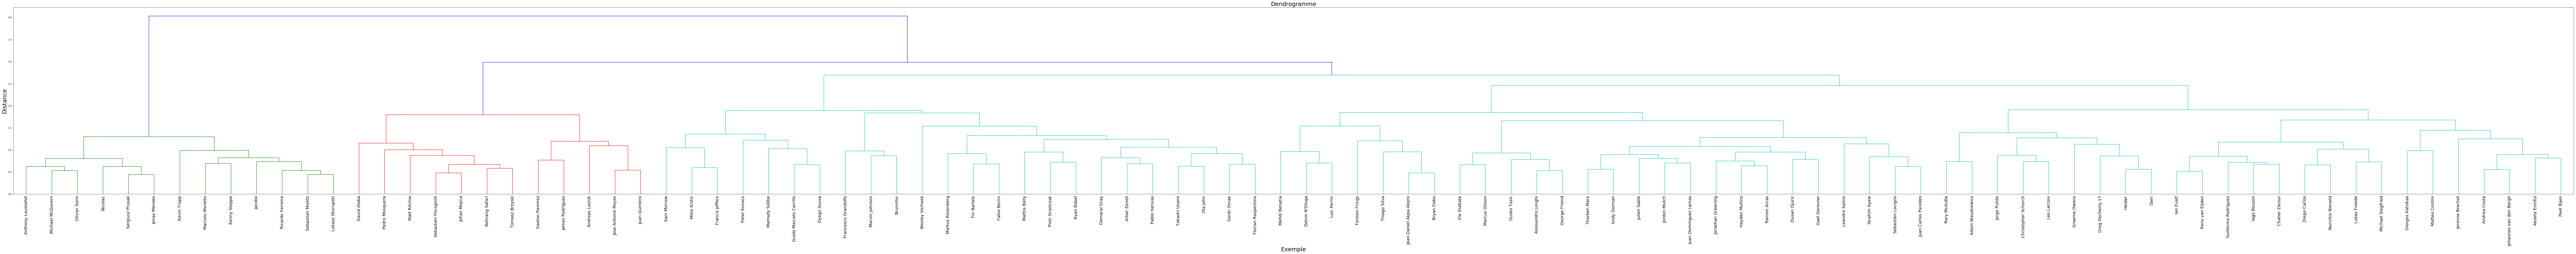

In [158]:
n = 100

data_fusion = cl2.clustering_hierarchique_max2(data_norm.iloc[a[0:n]].as_matrix(),"euclidienne",[ list_players_name[i] for i in a[0:n]] )

Affichage d'un dendrogramme plus explicite

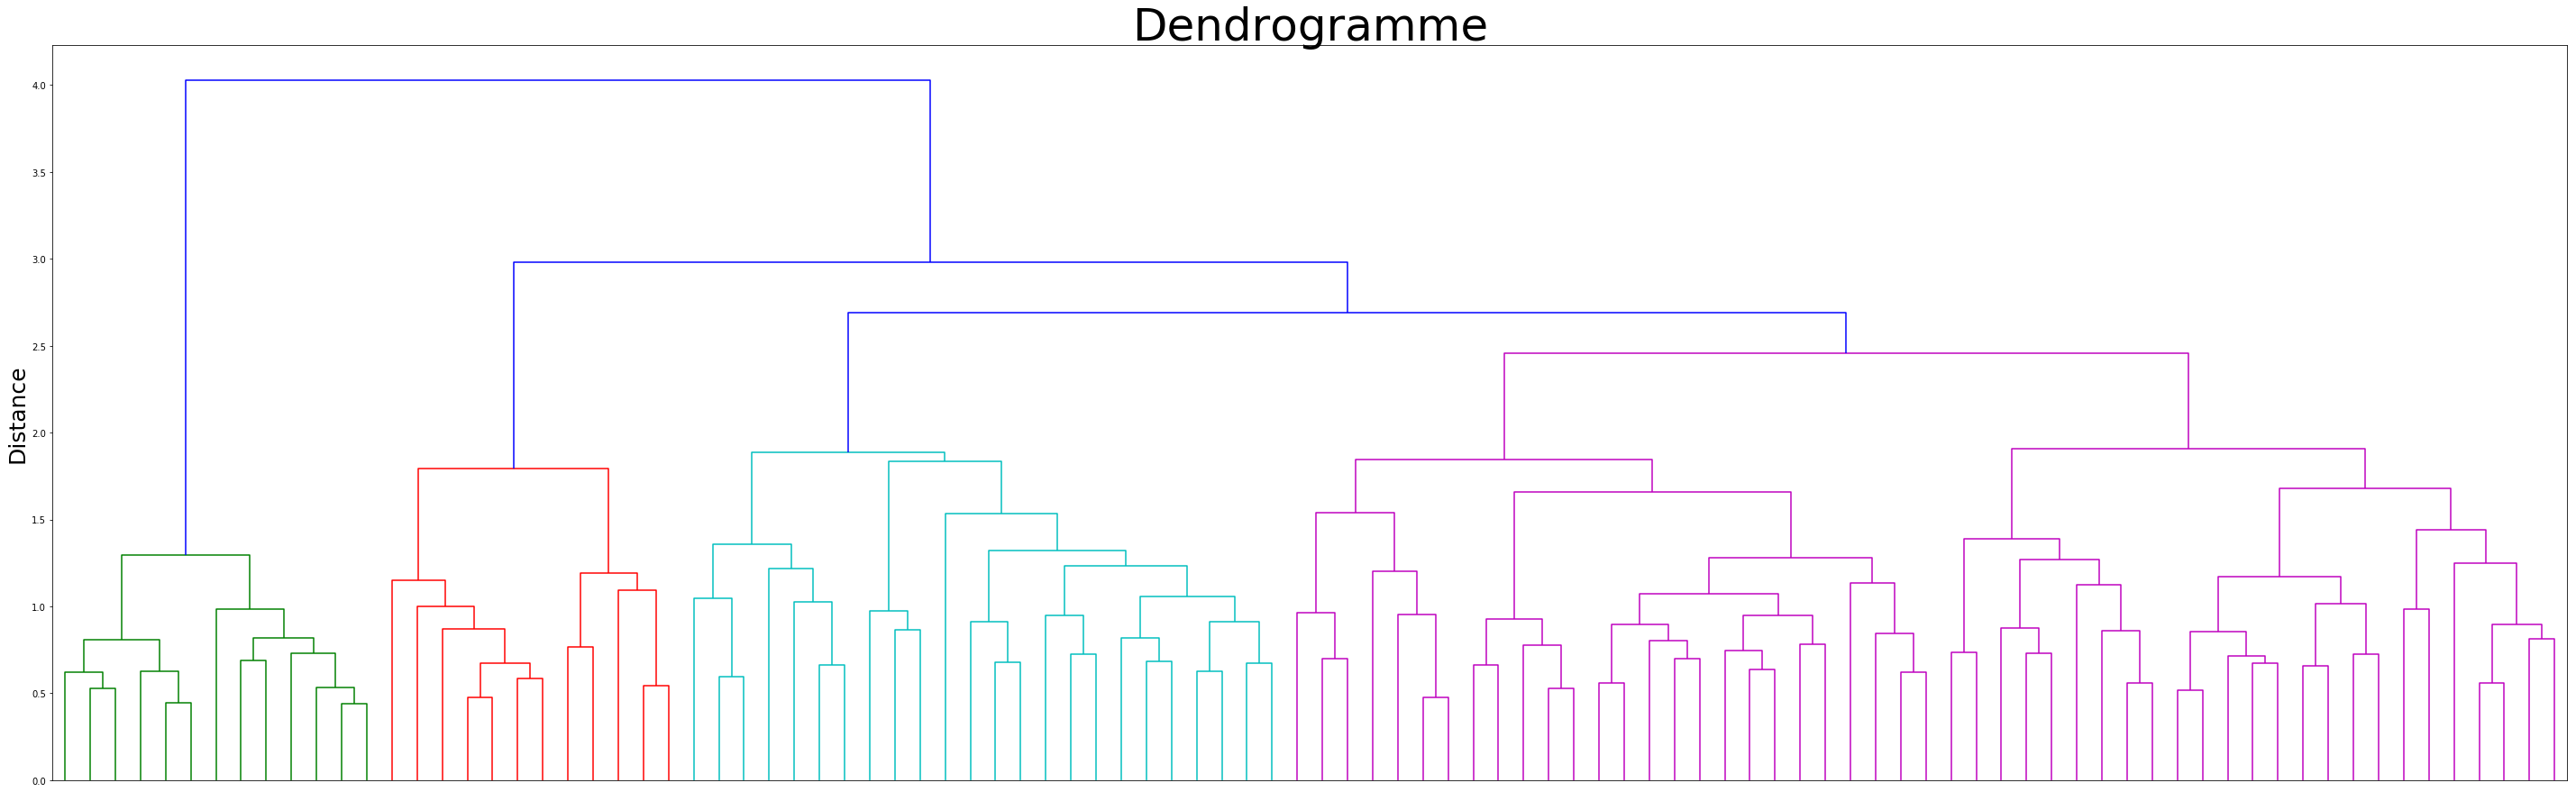

In [150]:
plt.figure(figsize=(50, 15)) # taille : largeur x hauteur
plt.title('Dendrogramme', fontsize=50)
plt.ylabel('Distance', fontsize=25)

# Construction du dendrogramme a partir de la matrice M_Fusion:
scipy.cluster.hierarchy.dendrogram(data_fusion,color_threshold = 2.5, no_labels = True)
plt.show()

Création des clusters avec une distance max de fusion dist_max

In [160]:
dist_max = 2.5
clusters = create_clusters(data_fusion, list_players_name2, dist_max)

print ("avec une distance max de =",dist_max,"  on trouve ",len(clusters)," clusters")
count = 0
keys = list(clusters.keys())
for cluster in keys:
    print("cluster ",count," de taille ",len(clusters[cluster]))
    count += 1



avec une distance max de = 2.5   on trouve  4  clusters
cluster  0  de taille  13
cluster  1  de taille  12
cluster  2  de taille  24
cluster  3  de taille  51


Calcul et affichage des caractéristiques de chaque cluster

In [147]:
list_caract = caracteristiques_custers(clusters, dataframe)
tmp = [i[0] for i in list_caract]

pd.concat(tmp, ignore_index=True)

/home/adrien/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,acceleration,aggression,agility,attacking_work_rate,balance,ball_control,crossing,curve,defensive_work_rate,dribbling,...,reactions,short_passing,shot_power,sliding_tackle,sprint_speed,stamina,standing_tackle,strength,vision,volleys
0,69.692308,68.461538,68.846154,high,64.538462,62.615385,53.923077,49.923077,medium,59.846154,...,66.153846,65.461538,62.307692,59.461538,69.000000,74.307692,62.384615,72.846154,58.461538,49.692308
1,59.333333,53.333333,59.083333,medium,57.250000,56.250000,46.166667,48.416667,medium,51.166667,...,65.916667,56.916667,51.666667,45.833333,57.333333,60.333333,48.666667,68.250000,52.166667,42.500000
2,71.500000,58.208333,69.250000,medium,65.750000,66.375000,59.375000,56.833333,medium,65.708333,...,64.333333,64.125000,63.166667,46.500000,73.291667,68.333333,50.041667,64.541667,60.166667,50.791667
3,65.666667,60.745098,63.784314,medium,63.333333,62.274510,54.098039,50.686275,medium,59.862745,...,63.960784,62.333333,60.705882,47.117647,66.450980,63.470588,48.411765,68.450980,56.156863,48.254902


# Execution sur toutes les données. Attention 7h de calcul sur ma machine.

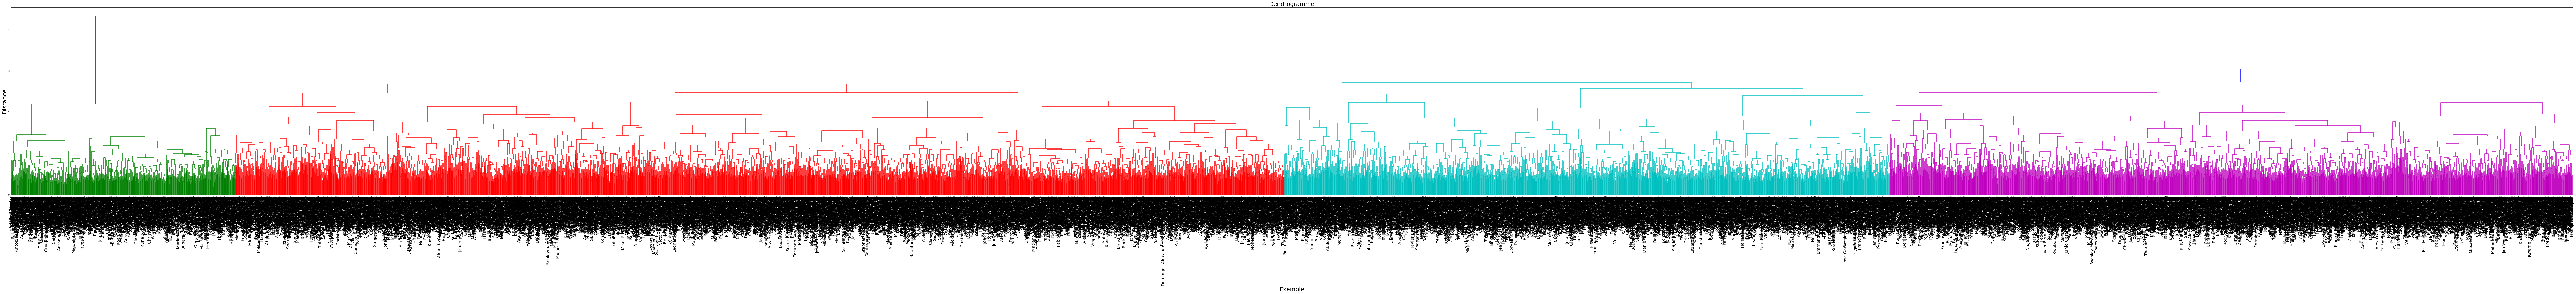

exec time in sec 25043.701759576797


In [60]:
start_time = time.time()
print()
data_fusion2 = cl2.clustering_hierarchique_max2(data_norm.as_matrix(),"euclidienne",list_players_name )
print("exec time in sec" ,time.time()- start_time)

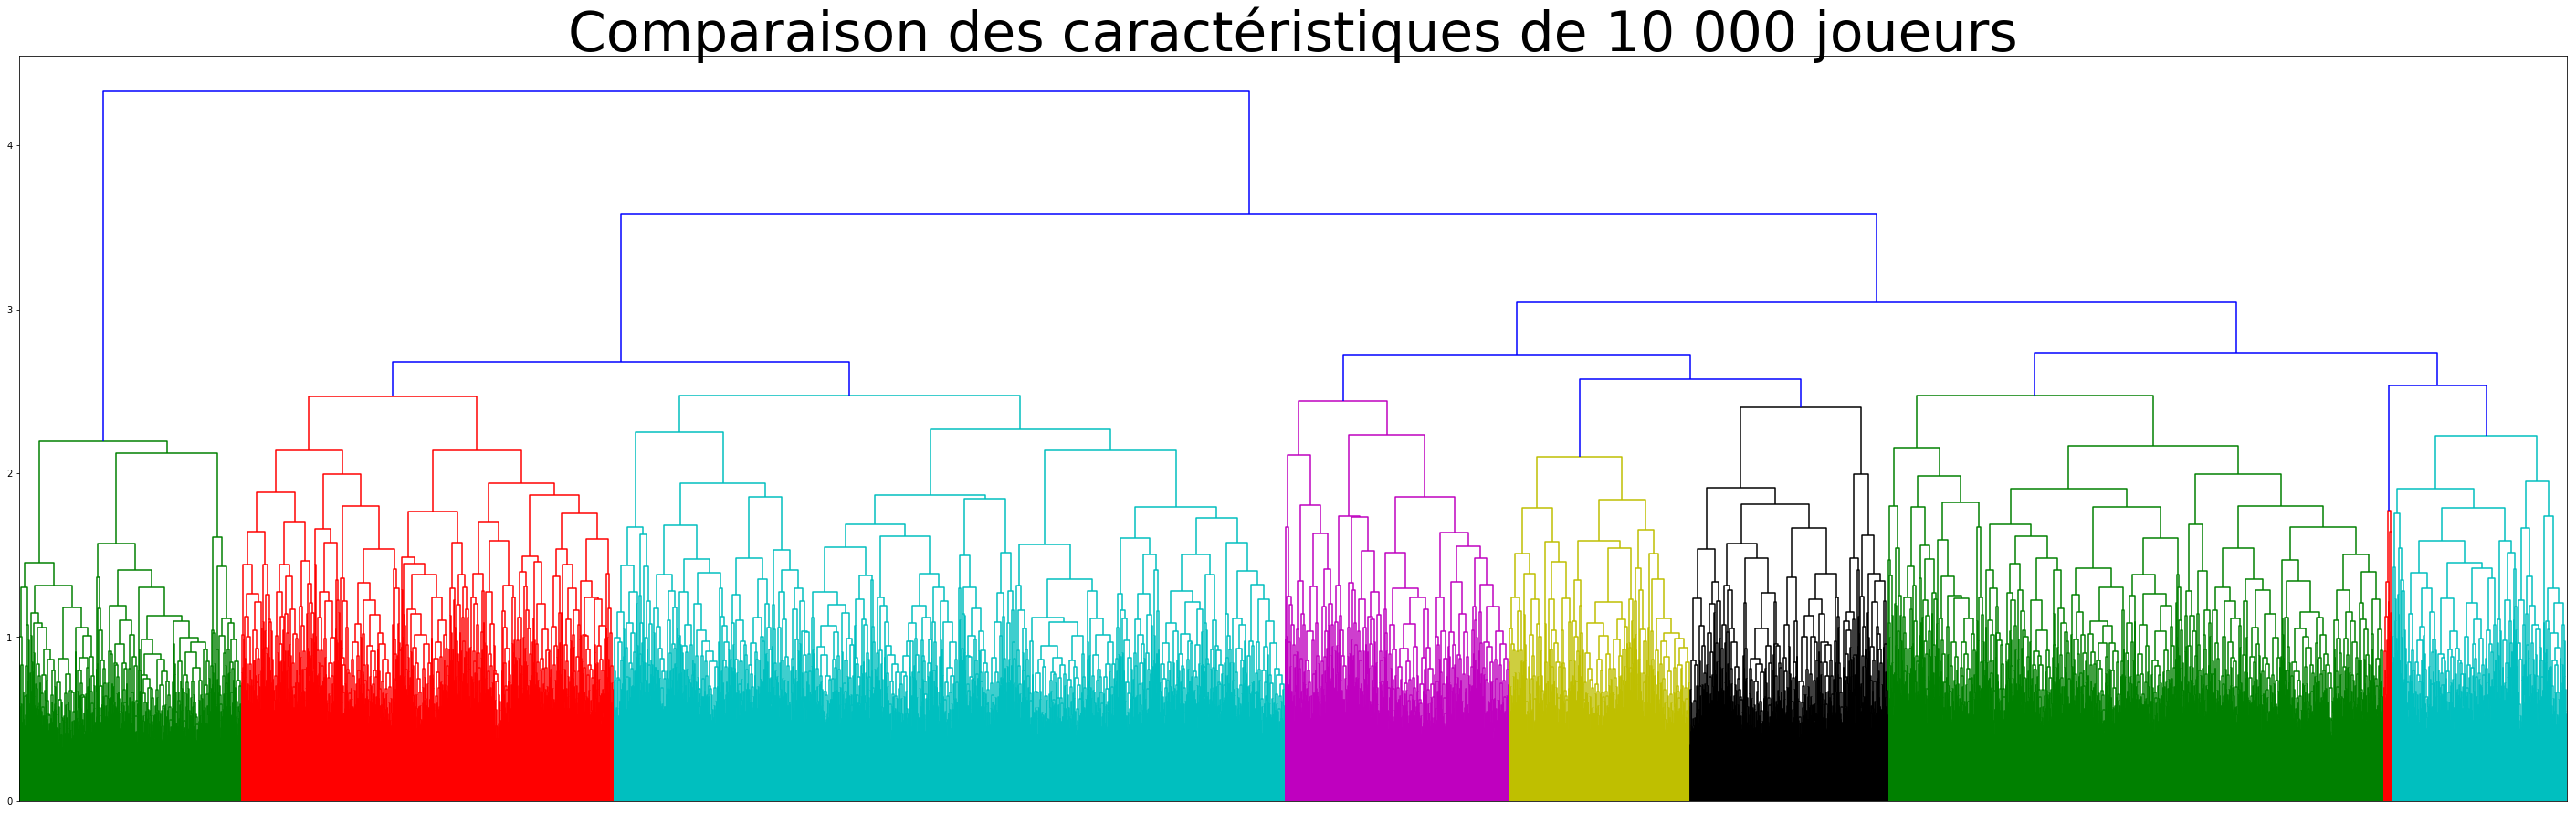

In [162]:
plt.figure(figsize=(50, 15)) # taille : largeur x hauteur
plt.title('Comparaison des caractéristiques de 10 000 joueurs', fontsize=60)
#plt.ylabel('Distance', fontsize=25)

# Construction du dendrogramme a partir de la matrice M_Fusion:
scipy.cluster.hierarchy.dendrogram(data_fusion2,color_threshold = 2.5, no_labels = True)
plt.show()

Création des clusters avec une distance max de fusion dist_max

In [110]:
dist_max = 2.5
clusters = create_clusters(data_fusion2, list_players_id, dist_max)


"""
print ("avec une distance max de =",dist_max,"  on trouve ",len(clusters)," clusters")
count = 0
keys = list(clusters.keys())
for cluster in keys:
    #print("\n",cluster, clusters[cluster])
    print("cluster ",count," de taille ",len(clusters[cluster]))
    count += 1

    for player in clusters[cluster]:
        print(list_players_name[player[0]])
    print("\n\n")
"""

'\nprint ("avec une distance max de =",dist_max,"  on trouve ",len(clusters)," clusters")\ncount = 0\nkeys = list(clusters.keys())\nfor cluster in keys:\n    #print("\n",cluster, clusters[cluster])\n    print("cluster ",count," de taille ",len(clusters[cluster]))\n    count += 1\n\n    for player in clusters[cluster]:\n        print(list_players_name[player[0]])\n    print("\n\n")\n'

In [106]:
list_caract = caracteristiques_custers(clusters, dataframe)

/home/adrien/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Affichage des caractéristiques moyennes de chaque cluster

In [105]:
tmp = [i[0] for i in list_caract]

pd.concat(tmp, ignore_index=True)

,acceleration,aggression,agility,attacking_work_rate,balance,ball_control,crossing,curve,defensive_work_rate,dribbling,...,reactions,short_passing,shot_power,sliding_tackle,sprint_speed,stamina,standing_tackle,strength,vision,volleys
0,55.878788,54.787879,63.484848,medium,69.818182,79.181818,71.636364,74.818182,low,73.575758,...,72.151515,77.787879,73.181818,33.515152,55.363636,48.272727,39.393939,63.363636,77.818182,69.757576
1,72.574648,67.915493,71.684507,high,70.321127,69.807042,68.439437,64.840845,medium,67.654930,...,67.500000,69.249296,69.604225,64.801408,72.514085,73.777465,66.198592,66.612676,62.609859,53.925352
2,42.915332,31.011442,45.136156,medium,44.620137,22.143021,16.040046,16.447368,medium,16.247140,...,64.860412,28.060641,24.814645,16.042334,43.043478,34.513730,15.906178,64.985126,33.521739,16.267735
3,62.422515,60.900585,61.581871,medium,56.929825,66.633041,50.754386,54.586257,low,63.592105,...,66.327485,61.380117,72.141813,25.027778,64.198830,62.033626,28.884503,76.698830,58.144737,64.453216
4,66.967742,72.618065,69.842581,high,69.621935,75.469677,70.393548,69.480000,high,71.421935,...,73.981935,76.388387,75.535484,65.156129,66.597419,75.068387,68.729032,70.649032,72.277419,62.574194
5,76.228929,56.818907,77.038724,medium,73.865604,76.681093,69.248292,71.799544,medium,76.200456,...,71.670843,72.916856,73.706150,33.165148,74.666287,68.052392,36.929385,62.298405,71.236902,67.839408
6,53.728953,68.633128,51.402464,medium,54.652977,55.030116,45.630390,40.084873,medium,45.457906,...,60.722793,57.546886,53.286790,64.446954,55.580424,62.156057,67.480493,75.201916,44.614648,33.262149
7,74.252956,50.888432,73.120823,high,70.474550,67.528021,57.876607,58.523393,medium,67.852956,...,62.820566,62.768123,66.157326,28.621594,73.961954,63.960925,30.984062,60.962468,59.924422,57.802057
8,65.516521,70.396126,64.123433,medium,64.691227,64.047095,56.136726,49.828333,medium,58.026965,...,65.605393,65.496772,60.382074,65.815040,66.270414,70.466388,67.976833,70.655146,55.216483,42.284087
